## Author: Yuqing Qiao
## Date: 02/23/2024
## Description: Skipgram and CBOW

#Task 1 Data Collection:
Download the text8 dataset, which is a cleaned version of the first 100MB of the English Wikipedia dump. It is available on several NLP data repositories.

In [1]:
#mount dataset file
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/Colab Notebooks/6120NLP/skipgram&CBOW/text8"

Mounted at /content/drive



##Task 2 Pre-processing:
Tokenize the dataset.
Remove stopwords and non-alphabetic tokens.
Build a vocabulary of the most frequent words (e.g., top 10,000 or 20,000 words).

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import numpy as np
import nltk
from collections import defaultdict

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Preprocessing the data

wn = nltk.WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
import re
import string
def clean_text(text):
    """Clean the text by removing stopwords and non-alphabetic tokens."""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stop_words])
    #text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text_cleaned


In [4]:
import os
#Hyper parameter
max_workers = os.cpu_count()+4
print("CPU core count: ",os.cpu_count())

CPU core count:  8


# Split text to num of threads runnable tasks for processing. clean text and get the frequency of words

In [5]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import os

def read_file(file_path):
  with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()
    return text

def chunkify(text, chunk_size:int = 100000):
    """Divide the words into chunks and process them in parallel."""
    words = text.split()
    for i in range(0, len(words), chunk_size):
        yield words[i:i+chunk_size]


def process_chunk(chunk):
    """Process a chunk of the file, tokenizing words."""
    freq_dict = defaultdict(int)

    cleaned_text = clean_text(" ".join(chunk))
    cleaned_chunk = cleaned_text.split()

    for token in cleaned_chunk:
        freq_dict[token] += 1

    return freq_dict,cleaned_text

def process_file_in_chunks(file_path):
    """Divide the file into chunks and process them in parallel."""
    text = read_file(file_path)
    chunks = chunkify(text)

    freq_dict = defaultdict(int)
    corpus =[]

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_chunk,chunk)for chunk in tqdm(chunks,desc="Submitting CHunks")]

        # Collect results as they complete
        for future in tqdm(as_completed(futures),total=len(futures),desc="Processing Chunks"):
            # Collect results as they complete
            freq_word,cleaned_chunk = future.result()
            corpus.append(cleaned_chunk)

            # Add the frequency dictionary to the main dictionary
            for word,freq in freq_word.items():
                freq_dict[word] += freq

    return freq_dict, corpus


In [6]:
%%time
#parallel process text to create dict frequency of words
freq_dict, corpus = process_file_in_chunks(file_path)

print("\nVocab in dict: ", len(freq_dict))
print("\nTexts in corpus: ",len(corpus))


Submitting CHunks: 1244it [00:35, 35.41it/s]
Processing Chunks: 100%|██████████| 1244/1244 [00:44<00:00, 28.19it/s]



Vocab in dict:  828067

Texts in corpus:  1244
CPU times: user 1min 1s, sys: 16.7 s, total: 1min 18s
Wall time: 1min 27s


In [ ]:
list(freq_dict.items())[:10]

[('account', 8772),
 ('hume', 851),
 ('born', 48741),
 ('two', 2339753),
 ('six', 1283953),
 ('th', 82990),
 ('april', 28614),
 ('one', 3776726),
 ('seven', 1123106),
 ('old', 38842)]

# Before optimization: using ThreadPoolExecutor spent time 7.5 mins, \#workers = 16

Submitting CHunks: 100%|██████████| 17/17 [00:00<00:00, 3021.19it/s]

Process Chunks: 100%|██████████| 17/17 [07:31<00:00, 26.57s/it]

## Hyper parameters: top k words, context window size 2

In [7]:
k = 2000 # top k freq words
context_window_size = 2 # context window size


## Get top k words and remove non top k freq words from corpus

In [8]:
import heapq

def top_k_words(freq_dict, k):
    """Find the top k words in a list of dictionaries."""
    top_words = set()
    heap_list = [(-freq,word) for word, freq in freq_dict.items()]
    heapq.heapify(heap_list)

    cnt = 0
    while cnt < k and heap_list:
        neg_freq, word = heapq.heappop(heap_list)
        top_words.add(word)
        cnt += 1

    return top_words

In [9]:
#top k frequent words
top_words = top_k_words(freq_dict, k)

print(len(top_words))

2000


In [10]:
#convert words to indexes
def words_to_id(words,dict_idx):
  return np.array([dict_idx[word] for word in words])

#convert indexes to words
def id_to_words(ids,dict_idx):
  return [dict_idx[idx] for idx in ids]


In [11]:
def filter_corpus(corpus,top_k_words):
  #filter corpus
  filtered_corpus = []
  for text in corpus:
    words = text.split()
    words = [word for word in words if word in top_k_words]
    filtered_corpus.append(" ".join(words))
  return filtered_corpus

In [12]:
# filtered words that are not in top k freq words in corpus
filtered_corpus = filter_corpus(corpus,top_words)

## TensorFlow tokenizer: Corpus

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [14]:
# TensorFlow tokenizer

tokenizer = Tokenizer(num_words=k,oov_token='<UNK>')
tokenizer.fit_on_texts(filtered_corpus)

print("vocab size: ", len(tokenizer.word_index))

vocab size:  2001


In [15]:
#Hyper parameter vocabulary size

V = len(tokenizer.word_index)

print("Vocab size: ",V)

Vocab size:  2001


In [16]:
# corpus words to id for training x and y
sequences = tokenizer.texts_to_sequences(filtered_corpus)


## Task 3 Implement CBOW:
Create the architecture for CBOW with an embedding layer and a linear layer.
Generate training samples. For each word in the dataset, use n surrounding words as context.
Train the model using a suitable optimizer and loss function.
Extract word embeddings for the vocabulary.

In [ ]:
# generate context to word sequence pair
def cbow_context_target_pairs(sequence, window_size):
    contexts = []
    targets = []
    for i in range(window_size, len(sequence)-window_size):
      start = i - window_size
      end = i + window_size + 1

      context = sequence[start:i] + sequence[i+1:end]
      target = sequence[i]
      contexts.append(context)
      targets.append(target)

    return contexts, targets

def generate_cbow_context_target_pairs(sequences, window_size):
  # context list and target word

  context_length = window_size * 2
  total_contexts = []
  total_targets = []

  # submit context target pair future tasks
  with ProcessPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(cbow_context_target_pairs,sequence,window_size) for sequence in sequences]

    # collect results
    for future in tqdm(as_completed(futures),total=len(futures)):
      contexts, targets = future.result()
      total_contexts.extend(contexts)
      total_targets.extend(targets)

  return np.array(total_contexts), np.array(total_targets)

In [ ]:
# cbow context to sequences, target words
cbow_context_seqs, cbow_target_seqs = generate_cbow_context_target_pairs(sequences, context_window_size)


100%|██████████| 1244/1244 [01:53<00:00, 10.95it/s]


In [ ]:
#same context size, no need for padding


# max_len = max([len(x) for x in cbow_context_seqs])

#max_len = context_window_size*2
# train_X = pad_sequences(cbow_context_seqs, maxlen=max_len)


In [19]:
# Hyper parameter
embedding_size = 128

#context_window_size
#V
#k

In [ ]:
# CBOW Model

def build_model(V, embed_size):
  # Build the CBOW model
  model = Sequential()
  model.add(Embedding(input_dim=V,
                      output_dim=embed_size,
                      input_length=2*context_window_size))
  model.add(Lambda(lambda x: tf.reduce_mean(x, axis=1)))
  model.add(Dense(units=V, activation='softmax'))

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=0.025), loss='sparse_categorical_crossentropy')

  return model


In [ ]:
train_X = cbow_context_seqs
train_y = cbow_target_seqs

print(train_X.shape)
print(train_y.shape)

(69646949, 4)
(69646949,)


In [ ]:
#CBOW model
cbow_model = build_model(V, embedding_size)
cbow_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 4, 100)            1000100   
                                                                 
 lambda_4 (Lambda)           (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 10001)             1010101   
                                                                 
Total params: 2010201 (7.67 MB)
Trainable params: 2010201 (7.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Train CBOW model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cbow_model.fit(
    x=train_X, y=train_y,
    batch_size = 4096,
    epochs=3,
    callbacks=[early_stopping],
    verbose=1)


Epoch 1/3
17004/17004 [==============================] - ETA: 0s - loss: 5.6027

17004/17004 [==============================] - 135s 8ms/step - loss: 5.6027
Epoch 2/3
17004/17004 [==============================] - ETA: 0s - loss: 5.5782

17004/17004 [==============================] - 104s 6ms/step - loss: 5.5782
Epoch 3/3
17004/17004 [==============================] - ETA: 0s - loss: 5.5765

17004/17004 [==============================] - 102s 6ms/step - loss: 5.5765


# CBOW Embedings

In [ ]:
import pandas as pd

cbow_embedding_weights = cbow_model.get_layer('embedding_4').get_weights()[0]
print(cbow_embedding_weights.shape)

word_index = tokenizer.word_index
pd.DataFrame(cbow_embedding_weights,index=[word for word,idx in word_index.items()]).head()


(10001, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
<UNK>,0.019586,0.032067,0.035112,-0.006281,-0.046120,0.001072,-0.019500,0.049969,-0.027328,0.006783,...,-0.042754,0.010400,-0.017955,-0.010453,-0.034061,0.008453,-0.030823,0.025729,-0.022810,0.002806
one,-0.549745,-0.535197,0.059421,-0.417282,-0.240004,-0.174795,0.263374,-0.517722,-0.420472,-0.134092,...,-0.886943,-0.276862,-0.673471,0.780026,0.938356,-0.727269,-0.119167,-0.148677,-0.561892,-0.412395
zero,0.048027,0.204600,-0.222074,0.085242,0.065988,0.019467,0.127048,0.232858,0.168859,-0.462567,...,0.079901,0.331933,0.189814,-0.070538,-0.020285,-0.018780,-0.045824,0.067248,0.050471,0.029892
two,0.069318,-0.309314,0.018670,0.240106,-0.108474,0.095792,0.093115,-0.102656,0.024929,0.105946,...,-0.061441,-0.390333,-0.058656,-0.092404,0.049985,0.085763,-0.060571,-0.029293,-0.198810,-0.120620
nine,0.132089,0.060155,0.155345,0.093602,0.138189,0.250400,0.107771,0.037310,-0.036837,-0.161549,...,-0.023878,-0.507402,-0.018635,0.100544,-0.061651,0.177738,0.050309,0.229738,0.294245,-0.105073


In [ ]:
# get corresponding word embedding vector
def get_cbow_embedding(word):
  word_index = tokenizer.word_index[word]
  if word_index is None:
    return None

  cbow_embedding_weights = cbow_model.get_layer('embedding_4').get_weights()[0]

  embedding = cbow_embedding_weights[word_index]
  return embedding


# Task 4 Implement Skipgram:

## Optimization: using negative sampling

In [ ]:
# # Define the negative sampling function

# def negative_sampling(target_word, context_words, sampling_table):
#   # Sample negative words based on the probability distribution
#   negative_words = tf.random.categorical(sampling_table, num_samples=num_negative_samples)
#   return target_word, context_words, negative_words


In [17]:
# generate context to word sequence pair
def skipgram_pairs(sequence, window_size):
    skip_grams = []
    for i in range(window_size, len(sequence)-window_size):
      start = i - window_size
      end = i + window_size + 1

      context = sequence[start:i] + sequence[i+1:end]
      target = sequence[i]
      for context_word in context:
        if context_word != target:
          skip_grams.append((target,context_word))

    return np.array(skip_grams)

# create target to context skipgram pairs
def generate_skipgram_pairs(sequences, window_size):
  # context list and target word

  context_length = window_size * 2
  pairs = []

  # submit context target pair future tasks
  with ProcessPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(skipgram_pairs,sequence,window_size) for sequence in sequences]

    # collect results
    for future in tqdm(as_completed(futures),total=len(futures)):
      skip_grams = future.result()
      pairs.extend(skip_grams)

  return pairs


In [18]:
# X is the skipgram center word, y is the context word.
skip_grams = generate_skipgram_pairs(sequences,context_window_size)


100%|██████████| 1244/1244 [00:59<00:00, 20.99it/s]


In [20]:
# Prepare X, y for skip-gram training
train_x_sgram = np.array([x[0] for x in skip_grams])
train_y_sgram = np.array([x[1] for x in skip_grams])

# Reshape train_x_sgram to match the input shape of the model
train_x_sgram = np.expand_dims(train_x_sgram, axis=-1)

del skip_grams


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense,Input
from tensorflow.keras.optimizers import Adam

def build_skipgram_model(vocab_size, embedding_dim):

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        name='word_embedding'))
    # model.add(Lambda(lambda x: tf.reduce_mean(x,axis=1)))
    model.add(Dense(units=vocab_size, activation='softmax')) # predicting context words shown or not shown
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.025))

    return model


In [22]:
sgram_model = build_skipgram_model(V, embedding_dim=embedding_size)
sgram_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_embedding (Embedding)  (None, None, 128)         256128    
                                                                 
 dense (Dense)               (None, None, 2001)        258129    
                                                                 
Total params: 514257 (1.96 MB)
Trainable params: 514257 (1.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:


sgram_model.fit(
    train_x_sgram,
    train_y_sgram,
    batch_size = 4096,
    epochs=3,
    # workers=4,
    verbose=1)


Epoch 1/3
50965/50965 [==============================] - 208s 4ms/step - loss: 5.5830
Epoch 2/3
50965/50965 [==============================] - 177s 3ms/step - loss: 5.5807
Epoch 3/3
50965/50965 [==============================] - 175s 3ms/step - loss: 5.5806


In [29]:
# sgram Embedding
def get_sgram_embedding(word):
    word_index = None
    if word not in tokenizer.word_index:
        return None

    word_index = tokenizer.word_index[word]
    embeddings = sgram_model.get_layer('word_embedding').get_weights()[0]
    embedding = embeddings[word_index]

    return embedding


# Task 5 Evaluation:

In [30]:
selected_word_pairs = [
  ('king', 'queen'),
  ('man', 'woman'),
  ('prince','princess'),
  ('paris', 'france'),
  ('china','japan'),
  ('italy', 'rome'),
  ('flight', 'plane'),
  ('orange','banana'),
  ('computer', 'keyboard'),
]

not_pair_words = [
  ('food','computer'),
  ('flight','kitchen'),
  ('school','stone')
]

In [26]:
# vector similarity between embedding vectors
def cosine_similarity(embedding1, embedding2):
    dot_product = np.dot(embedding1, embedding2)
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    similarity = dot_product / (norm1 * norm2)
    return similarity


In [31]:
# words embedding consine similarity on selected word pairs
def print_similarity(word_pairs,get_embedding_func):
   for word_pair in word_pairs:
      word1, word2 = word_pair
      embedding1 = get_embedding_func(word1)
      embedding2 = get_embedding_func(word2)
      if embedding1 is None or embedding2 is None:
          print(f"Embedding for {word1} or {word2} not found.")

      else:
          similarity = cosine_similarity(embedding1, embedding2)
          print(f"Similarity between {word1} and {word2}: {similarity}")


## Non similar word pairs similarity : CBOW

In [ ]:
print_similarity(not_pair_words,get_cbow_embedding)

Similarity between food and computer: 0.0009429251658730209
Similarity between flight and kitchen: 0.07535284757614136
Similarity between school and stone: -0.018425162881612778


## Related word pairs similarity: CBOW

In [ ]:
# Print CBOW similarity on selected words
print_similarity(selected_word_pairs,get_cbow_embedding)


Similarity between king and queen: 0.31147491931915283
Similarity between man and woman: 0.4846438467502594
Similarity between prince and princess: 0.53116774559021
Similarity between paris and france: 0.43622562289237976
Similarity between china and japan: 0.48832011222839355
Similarity between italy and rome: 0.40073686838150024
Similarity between flight and plane: 0.24015115201473236
Similarity between orange and banana: 0.09845422953367233
Similarity between computer and keyboard: 0.32266050577163696


## Related word pairs similarity: Skip-gram

In [32]:
# Print Sgram similarity on selected words
print_similarity(selected_word_pairs,get_sgram_embedding)


Similarity between king and queen: 0.3251740038394928
Similarity between man and woman: 0.1635817438364029
Similarity between prince and princess: 0.33063000440597534
Similarity between paris and france: 0.2688509225845337
Similarity between china and japan: 0.28059935569763184
Similarity between italy and rome: 0.1173832044005394
Similarity between flight and plane: 0.08837147057056427
Embedding for orange or banana not found.
Embedding for computer or keyboard not found.


## Un-related word pairs similarity: Skip-gram

In [33]:
print_similarity(not_pair_words,get_sgram_embedding)

Similarity between food and computer: 0.023624571040272713
Embedding for flight or kitchen not found.
Similarity between school and stone: 0.08895199000835419


In [37]:
# destruct the word pairs to list of words
selected_words = [word for pair in selected_word_pairs for word in pair]

selected_words

['king',
 'queen',
 'man',
 'woman',
 'prince',
 'princess',
 'paris',
 'france',
 'china',
 'japan',
 'italy',
 'rome',
 'flight',
 'plane',
 'orange',
 'banana',
 'computer',
 'keyboard']

In [ ]:
#cbow embeddings on selected words
selected_cbow_embeddings = [get_cbow_embedding(word) for word in selected_words if get_cbow_embedding(word) is not None]


In [46]:
# get skipgram word embeddings on selected words

#find corresponding word in pairs
def find_pair_word(word, pairs):
    for pair in selected_word_pairs:
        if word in pair:
            return pair[0] if word == pair[1] else pair[1]
    return None

# for pca visual
def prepare_visualization_data(get_embedding_func,word_embeddings,pairs):
  skipgram_embeddings = [] # embedding
  labels = [] # embedding word labels
  skip_words = set() # words in selected pairs but not found in embedding
  word_pairs = []

  words =[word for pair in pairs for word in pair]

  for word in words:
    embedding = get_embedding_func(word)
    if embedding is None:
        skip_words.add(find_pair_word(word, pairs))
        skip_words.add(word)
    if embedding is not None and word not in skip_words:
        skipgram_embeddings.append(embedding)
        labels.append(word)
        word_pairs.append((word, find_pair_word(word, pairs)))

  return skipgram_embeddings, labels, word_pairs


## PCA Visualization: CBOW

In [45]:
# Get the word embeddings
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visual_pca(word_embeddings, word_labels, pairs):
  # 2 dimention visual
  pca = PCA(n_components=2)
  reduced_embeddings = pca.fit_transform(word_embeddings)

  num_embeddings = reduced_embeddings.shape[0]

  # Visualize the embeddings
  plt.figure(figsize=(10, 10))

  label_coords = {}

  for i, label in enumerate(word_labels):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points',
                 ha='right', va='bottom')

    label_coords[label] = (x, y) #label coordinates

    #draw connected line
    for word1, word2 in pairs:
      if word1 in label_coords and word2 in label_coords:
            x1, y1 = label_coords[word1]
            x2, y2 = label_coords[word2]
            plt.plot([x1, x2], [y1, y2], color='lightgrey', linestyle='--', linewidth=1)  # Draw a dotted line between the pair

  plt.show()

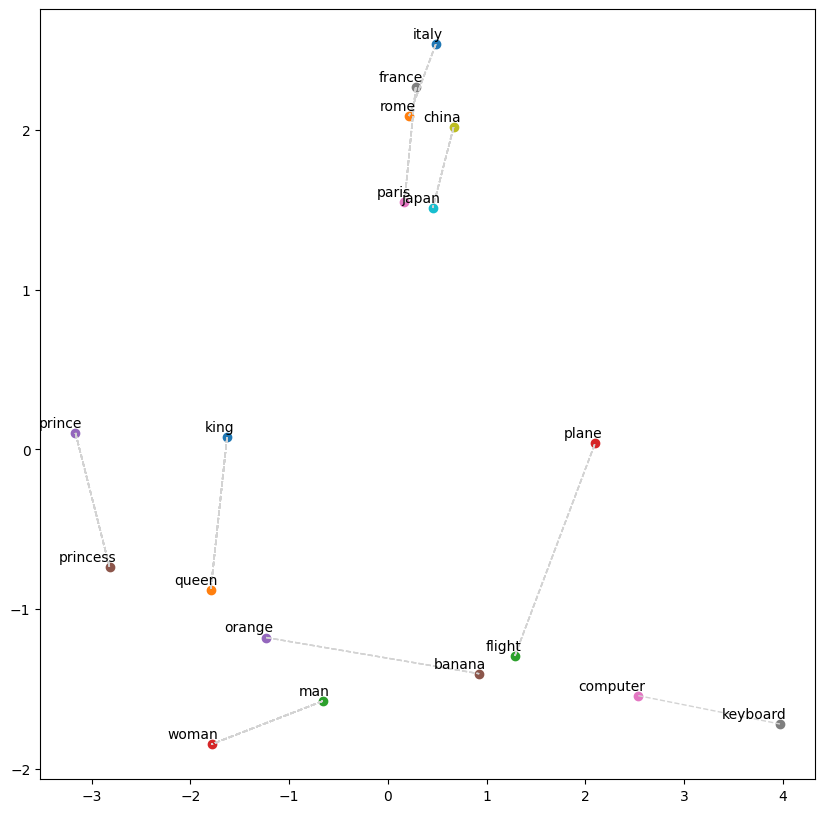

In [ ]:
#cbow pca
visual_pca(selected_cbow_embeddings, selected_words,selected_word_pairs)


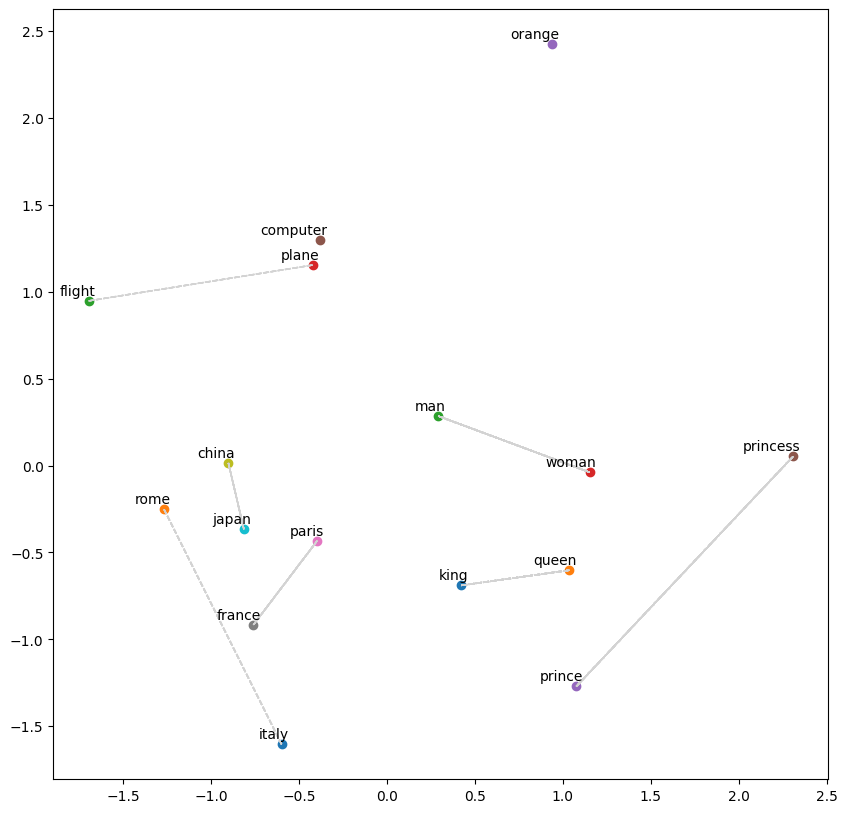

In [47]:
sg_embeddings, sg_labels, sg_word_pairs = prepare_visualization_data(get_sgram_embedding,skipgram_embeddings,selected_word_pairs)
#sgram pca
visual_pca(sg_embeddings, sg_labels,sg_word_pairs)
